In [1]:
import lbg_forecast.priors as pr
import numpy as np
import matplotlib.pyplot as plt

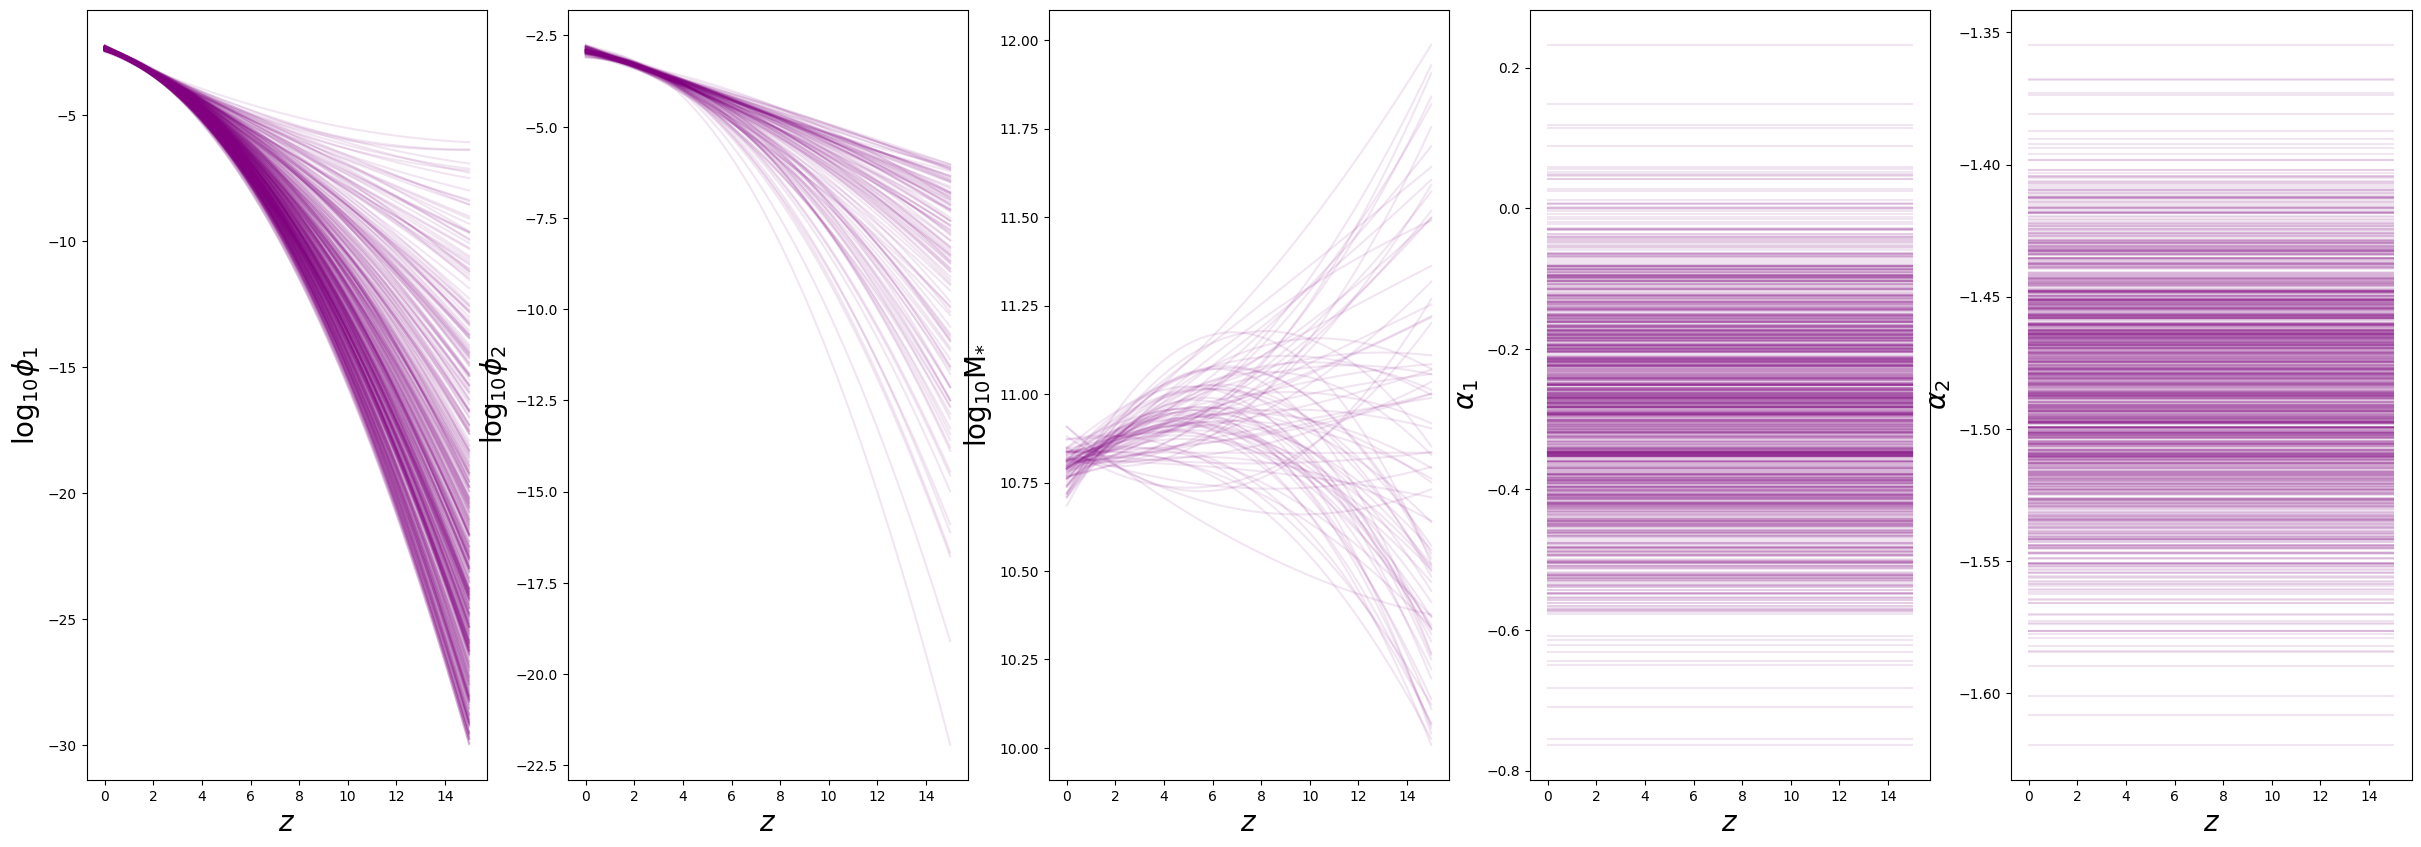

In [2]:
z_grid = np.linspace(0.0, 15.0, 50)
nsamples=1000
curves = pr.mass_function_parameter_curves(z_grid, nsamples, truth=False)
selected_curves = pr.select_allowed_parameter_curves(z_grid, curves)
pr.plot_mass_function_parameter_curves(z_grid, selected_curves, alpha=0.1)


(1000, 50) (1000, 50) (1000, 50) (1000, 50) (1000, 50)


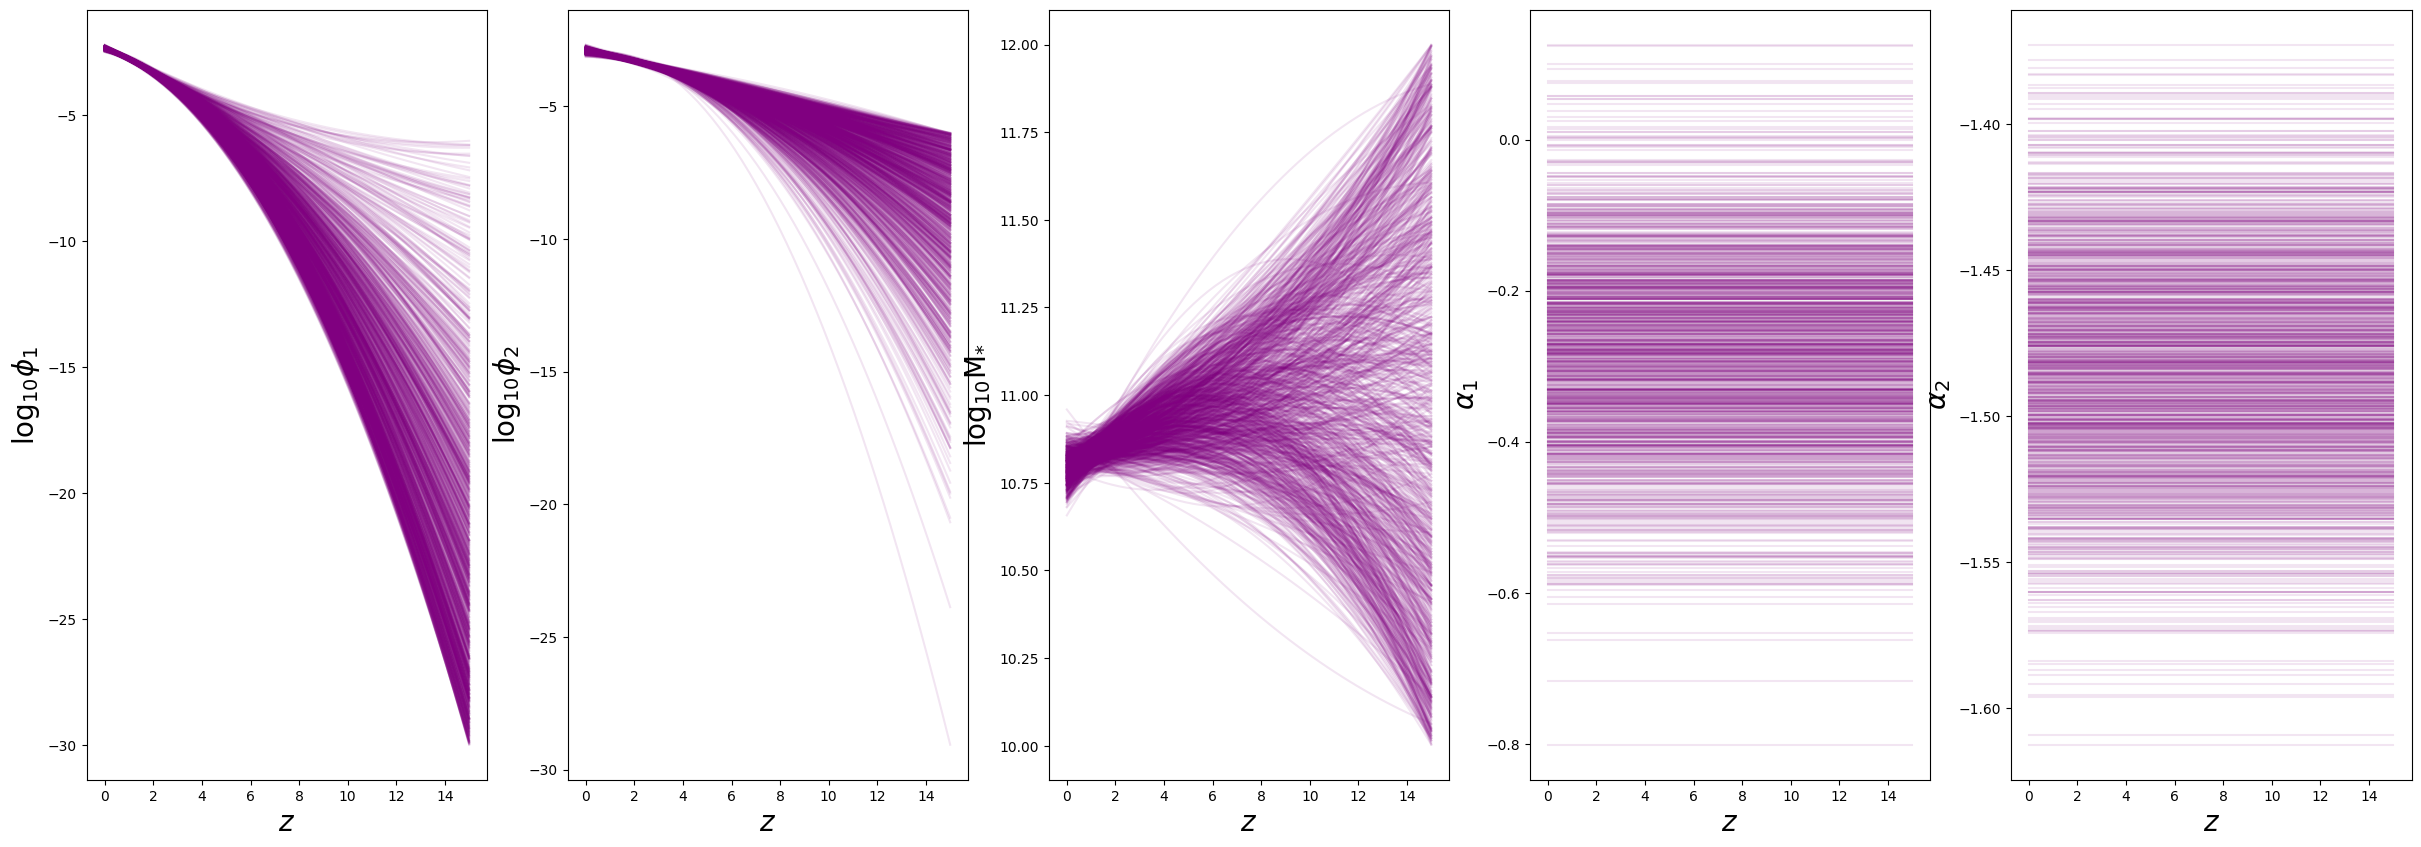

In [3]:
z_grid = np.linspace(0.0, 15.0, 50)
nsamples=1000000
curves = pr.mass_function_parameter_curves(z_grid, nsamples, truth=False)
allowed_curves = pr.select_allowed_parameter_curves(z_grid, curves)

sampled_curves = pr.sample_allowed_parameter_curves(z_grid, 1000, allowed_curves)
print(sampled_curves[0].shape, sampled_curves[1].shape, sampled_curves[2].shape, sampled_curves[3].shape, sampled_curves[4].shape)
pr.plot_mass_function_parameter_curves(z_grid, sampled_curves, alpha=0.1)

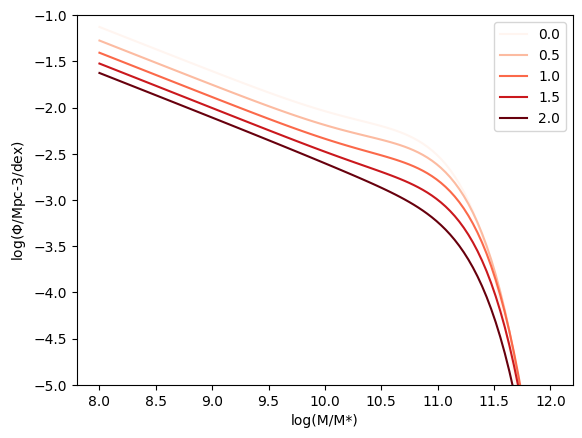

In [4]:
pr.plot_observed_mass_function()

(0.0, 3.0)

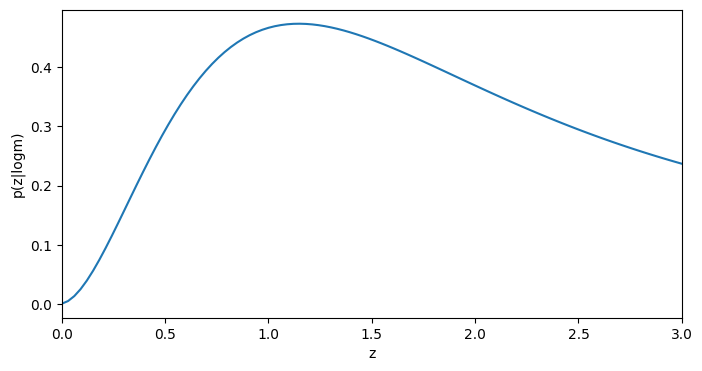

In [5]:
plt.figure(figsize=(8,4))
pr.plot_observed_nz()
plt.xlim(0, 3)

Text(0.5, 0, 'z')

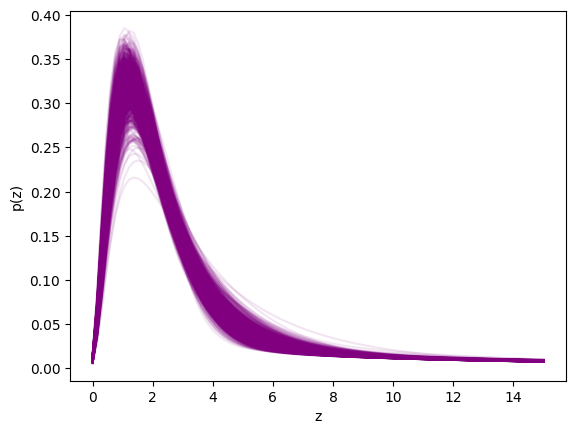

In [6]:
z_grid = np.linspace(0.0, 15.0, 100)
logm_grid = np.linspace(7, 13, 10)
init_sample=100000
nsamples = 1000
sampled_curves = pr.draw_allowed_parameter_curves(z_grid, init_sample, nsamples)
nzs = pr.draw_nz_prior(z_grid, logm_grid, sampled_curves)
pr.plot_nz_prior_draws(z_grid, nzs, nsamples)
plt.ylabel('p(z)')
plt.xlabel('z')

Text(0.5, 0, 'log(m)')

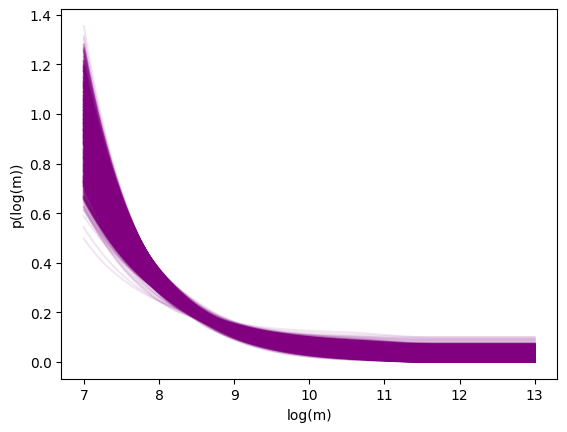

In [7]:
z_grid = np.linspace(0.0, 15.0, 5)
logm_grid = np.linspace(7, 13, 100)
init_sample = 100000
nsamples = 1000
sampled_curves = pr.draw_allowed_parameter_curves(z_grid, init_sample, nsamples)
mass_priors = pr.draw_mass_prior(z_grid, logm_grid, sampled_curves)
pr.plot_mass_prior_draws(logm_grid, mass_priors, nsamples)
plt.ylabel('p(log(m))')
plt.xlabel('log(m)')

In [8]:
dz, dlogm = 0.1, 0.05
z_min, z_max = 0.0, 15.0
logm_min, logm_max = 7.0, 13.0
grid_params = np.array([dz, dlogm, z_min, z_max, logm_min, logm_max])

z_grid, logm_grid = pr.setup_grids(grid_params)

priors = pr.load_priors(z_grid, logm_grid, 100, init_sample=10000)


Text(0.5, 0, 'log(m)')

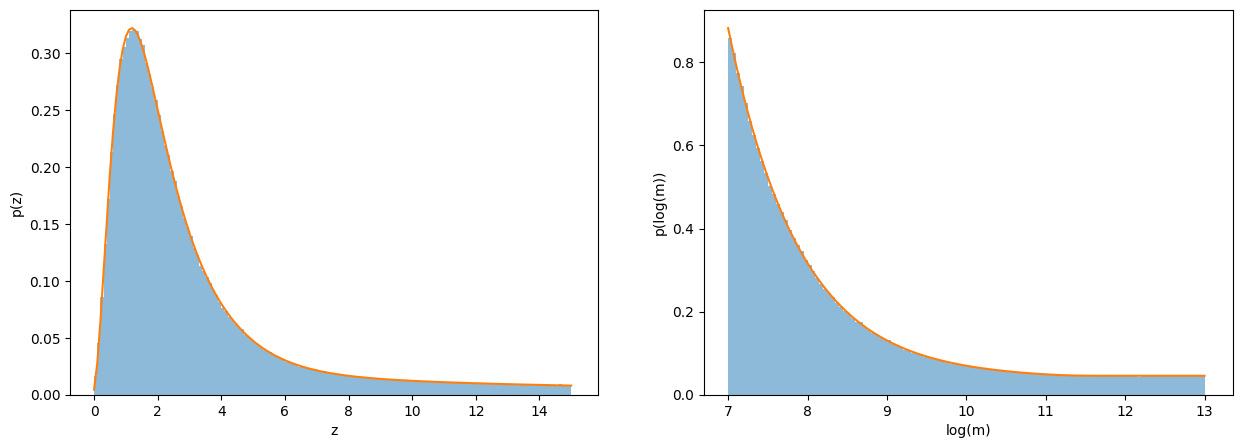

In [9]:
z_samples, m_samples, p_z, p_m = pr.sample_priors(z_grid, logm_grid, priors, grid_params, 1000000, plotting=True)
z_bins, m_bins = pr.setup_bins(grid_params)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].hist(z_samples, density=True, alpha=0.5, bins = z_bins)
axes[0].plot(z_grid, p_z)
axes[0].set_ylabel('p(z)')
axes[0].set_xlabel('z')

axes[1].hist(m_samples, density=True, alpha=0.5, bins = m_bins)
axes[1].plot(logm_grid, p_m)
axes[1].set_ylabel('p(log(m))')
axes[1].set_xlabel('log(m)')
